<a href="https://colab.research.google.com/github/mat669/DSE-AMD-project/blob/main/Copia_di_TPU_PROGETTO_AMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPU DISTRIBUTION STRATEGY

Enabling TPU strategy:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down.

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(23)
import random
random.seed(80)

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
from google.colab import auth

auth.authenticate_user()

# LICENSE ATTRIBUTION

The dataset adopted has been used according to the license reported at the following link: https://creativecommons.org/licenses/by/4.0/legalcode. 

# STORING DATA IN GCS BUCKET

The following code has been run in order to create a TFrecordFiles of the image dataset in order to deal efficiently with training involving TPUs.

In [ ]:
# !gsutil cp -r gs://amd_project_comics_faces/comics.zip /content

In [ ]:
# !gsutil cp -r gs://amd_project_comics_faces/faces.zip /content

In [ ]:
# !unzip comics.zip -d /content/data

In [ ]:
# !unzip faces.zip -d /content/data

In [ ]:
#from PIL import Image
#import os

#main_dir = "/content/data"
#paths = os.listdir(main_dir)[:2]
#comics_faces = []
#for path in paths:
#  images = os.scandir(os.path.join(main_dir,path)) 
#  for image in images:
#    comics_faces.append(os.path.join(os.path.join(main_dir,path),image))

In [ ]:
#def get_labels(image_path):
#  return 1 if '/faces' in image_path else 0

In [ ]:
#labels = list(map(get_labels, comics_faces))

In [ ]:
#image_labels = dict(zip(comics_faces,labels))

In [ ]:
#image_string = open(comics_faces[0], 'rb').read()

In [ ]:
#def _bytes_feature(value):
#  if isinstance(value, type(tf.constant(0))):
#    value = value.numpy() 
#  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#def _float_feature(value):
#  """Returns a float_list from a float / double."""
#  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

#def _int64_feature(value):
#  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
# Create a dictionary with features that may be relevant.
#def image_example(image_string, label):
#  image_shape = tf.io.decode_jpeg(image_string).shape

#  feature = {
#      'height': _int64_feature(image_shape[0]),
#      'width': _int64_feature(image_shape[1]),
#      'depth': _int64_feature(image_shape[2]),
#      'label': _int64_feature(label),
#      'image_raw': _bytes_feature(image_string),
#  }

#  return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
#record_file = 'images.tfrecords'
#with tf.io.TFRecordWriter(record_file) as writer:
#  for filename, label in image_labels.items():
#    image_string = open(filename, 'rb').read()
#    tf_example = image_example(image_string, label)
#    writer.write(tf_example.SerializeToString())

Then, "record_file" has been downloaded and uploaded into the GCS bucket.

# IMPORTING AND PREPROCESSING DATA

In [ ]:
from PIL import Image
import IPython.display as display

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

gcs_pattern = 'gs://amd_project_comics_faces/images.tfrecords'
filenames = tf.io.gfile.glob(gcs_pattern)

raw_image_dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads = AUTOTUNE)

# Create a dictionary describing the features.
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  example = tf.io.parse_single_example(example_proto, image_feature_description)
  decoded = tf.image.decode_jpeg(example['image_raw'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0
  normalized = tf.image.resize(normalized, (64,64))
  return normalized, example['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Shuffling the dataset since comics and faces have been uploaded sequentially, therefore the first 10000 instances represent comics.

In [ ]:
parsed_image_dataset = parsed_image_dataset.shuffle(buffer_size = 20000,seed = 10)

In [ ]:
split_train_val = 0.8
dataset = parsed_image_dataset.take(int(20000*split_train_val))
train_set = dataset.take(int(16000*split_train_val))
validation_set = dataset.skip(int(16000*split_train_val))
test_set = parsed_image_dataset.skip(int(20000*split_train_val))

In [ ]:
val_batch_size = int(20000*0.8*0.2)
train_batch_size = int(20000*0.8*0.8)
test_batch_size = int(20000*0.2)

In [ ]:
def prepare_training_data(data, batch_size = 100):
  data = data.cache()
  data = data.shuffle(train_batch_size,reshuffle_each_iteration = True)
  data = data.repeat()
  data = data.batch(batch_size, drop_remainder=True,num_parallel_calls=AUTOTUNE)
  data = data.prefetch(AUTOTUNE)
  return data

training_dataset = prepare_training_data(train_set)

def prepare_test_data(data, batch_size = 4000):
  data = data.cache()
  data = data.batch(batch_size, drop_remainder=True,num_parallel_calls=AUTOTUNE)
  data = data.repeat()
  return data

validation_dataset = prepare_test_data(validation_set,val_batch_size)
test_dataset = prepare_test_data(test_set,test_batch_size)

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets


class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 16000//batch_size

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)

# FIRST MODEL



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 100

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
: Model Initialize
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
with strategy.scope():
  model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(64,64,3, )),
])
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))    
  
  model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()


plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 1)                 12289     
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


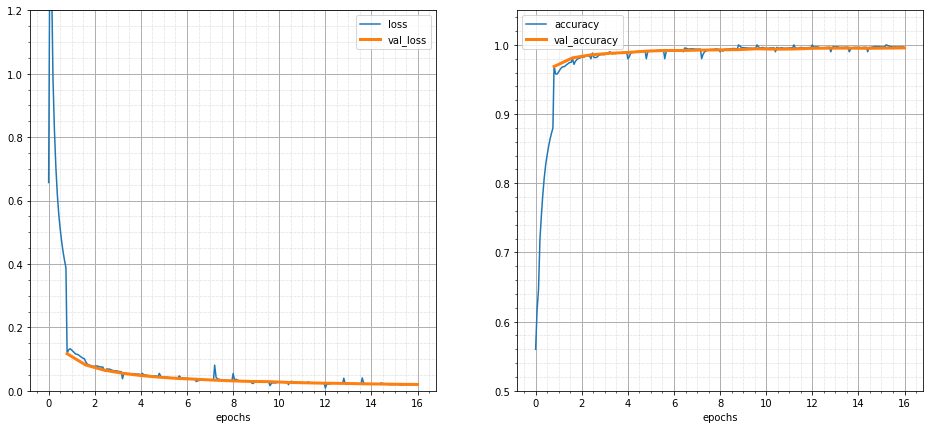

128/128 [==============================] - 4s 29ms/step - loss: 0.0195 - accuracy: 0.9969 - val_loss: 0.0200 - val_accuracy: 0.9956


In [ ]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets

import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from IPython.display import display, Javascript, clear_output, HTML
from google.colab import output
import io, base64


steps_per_epoch = 12800//batch_size
epochs = 20

history = model.fit(training_dataset,
                    epochs=epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_dataset,
                    validation_steps = 1,
                    initial_epoch = 0,
                    callbacks = [plot_training])

In [ ]:
result = []
histories = []

In [ ]:
histories.append(history)
result.append(model.evaluate(test_dataset, steps = 1))

1/1 [==============================] - 12s 12s/step - loss: 0.0199 - accuracy: 0.9975


In [ ]:
#Check of accuracy
from sklearn import metrics

images,true_labels = test_dataset.take(1).get_single_element()
predictions = model.predict_on_batch(images)
metrics.accuracy_score(np.round(predictions),true_labels.numpy())

0.997

In [ ]:
mistakes_baseline = []
for index in range(len(predictions)):
  if np.round(predictions)[index] != true_labels[index]:
    mistakes_baseline.append(index)
print(len(mistakes_baseline))

12


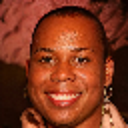

1

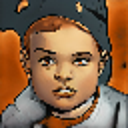

1

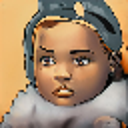

1

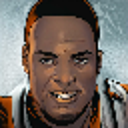

1

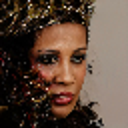

1

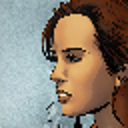

1

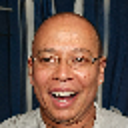

1

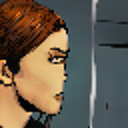

1

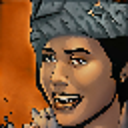

1

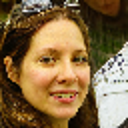

1

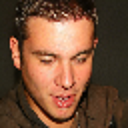

1

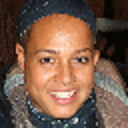

1

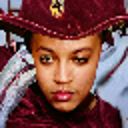

1

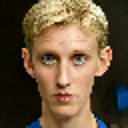

1

In [ ]:
for el in mistakes_baseline:
  img = tf.keras.preprocessing.image.array_to_img(images.numpy()[el])
  display(img.resize((128,128)),Image.LANCZOS)

# TUNING HYPERPARAMAMETERS: BATCH SIZE

The focus is here on tuning the hyperparamter "batch size", while the pattern of "epoch" hyperparamter has been intended as the more the better, since the greater the number of epochs, the greater the validation accuracy until reaching 0-increment.

In [ ]:
batch_size = [80, 100, 125, 150]
val_accuracies = []
epochs = 20
for el in batch_size:
  training_grid = prepare_training_data(train_set,el)
  validation_grid = prepare_training_data(validation_set,val_batch_size)
  with strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(64,64,3, )),
        ])
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))  
    
    model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

  history = model.fit(training_grid,
                    epochs=epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_grid,
                    validation_steps = 1,
                    initial_epoch = 0
                    )
  val_accuracies.append(history.history['val_accuracy'][-1])
optimal_batch_size = batch_size[np.argmax(val_accuracies)]
optimal_batch_size


Epoch 1/20
128/128 [==============================] - 25s 105ms/step - loss: 0.3497 - accuracy: 0.8820 - val_loss: 0.1146 - val_accuracy: 0.9703
Epoch 2/20
128/128 [==============================] - 2s 18ms/step - loss: 0.1027 - accuracy: 0.9743 - val_loss: 0.0776 - val_accuracy: 0.9837
Epoch 3/20
128/128 [==============================] - 2s 18ms/step - loss: 0.0734 - accuracy: 0.9827 - val_loss: 0.0628 - val_accuracy: 0.9891
Epoch 4/20
128/128 [==============================] - 2s 19ms/step - loss: 0.0606 - accuracy: 0.9865 - val_loss: 0.0532 - val_accuracy: 0.9906
Epoch 5/20
128/128 [==============================] - 2s 19ms/step - loss: 0.0510 - accuracy: 0.9893 - val_loss: 0.0507 - val_accuracy: 0.9897
Epoch 6/20
128/128 [==============================] - 2s 18ms/step - loss: 0.0449 - accuracy: 0.9898 - val_loss: 0.0418 - val_accuracy: 0.9919
Epoch 7/20
128/128 [==============================] - 2s 17ms/step - loss: 0.0410 - accuracy: 0.9918 - val_loss: 0.0379 - val_accuracy: 0.99

150

In [ ]:
training_data_opt = prepare_training_data(train_set, optimal_batch_size)
validation_data_opt = prepare_test_data(validation_set, val_batch_size)
test_data_opt = prepare_test_data(test_set,test_batch_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = optimal_batch_size

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
: Model Initialize
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
with strategy.scope():
  model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(64,64,3, )),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1,activation = 'sigmoid')
  ])
  
  model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 12289     
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


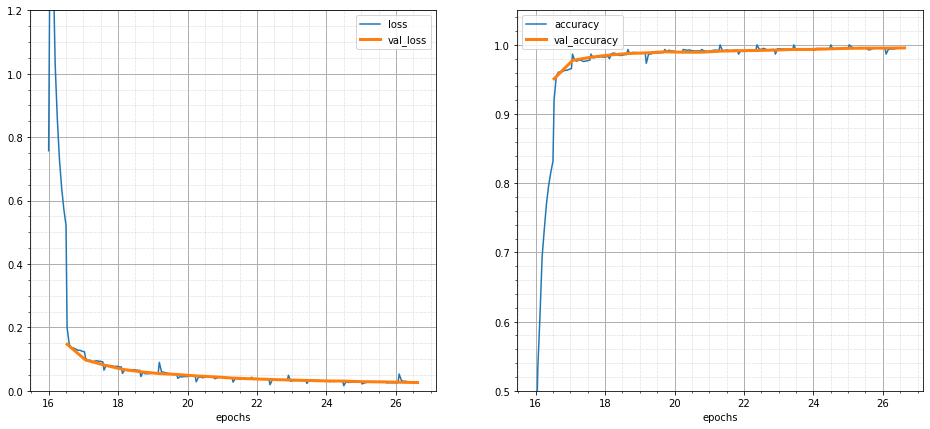

85/85 [==============================] - 3s 36ms/step - loss: 0.0258 - accuracy: 0.9956 - val_loss: 0.0260 - val_accuracy: 0.9956


In [ ]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets

import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from IPython.display import display, Javascript, clear_output, HTML
from google.colab import output
import io, base64


steps_per_epoch = 12800//optimal_batch_size

history = model.fit(training_data_opt,
                    epochs=20,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_data_opt,
                    validation_steps = 1,
                    initial_epoch = 0,
                    callbacks = [plot_training])

In [ ]:
histories.append(history)
result.append(model.evaluate(test_data_opt, steps = 1))

1/1 [==============================] - 12s 12s/step - loss: 0.0259 - accuracy: 0.9950


In [ ]:
images,true_labels = test_data_opt.take(1).get_single_element()
predictions = model.predict_on_batch(images)
metrics.accuracy_score(np.round(predictions),true_labels.numpy())

0.995

In [ ]:
mistakes_optimal = []
for index in range(len(predictions)):
  if np.round(predictions)[index] != true_labels[index]:
    mistakes_optimal.append(index)
print(len(mistakes_optimal))


20


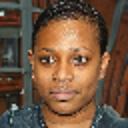

1

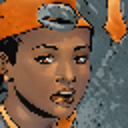

1

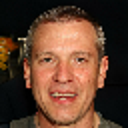

1

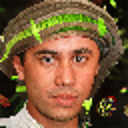

1

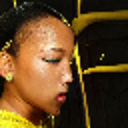

1

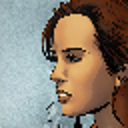

1

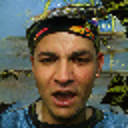

1

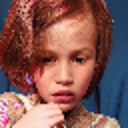

1

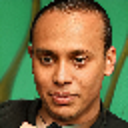

1

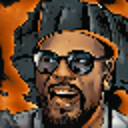

1

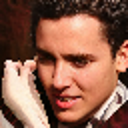

1

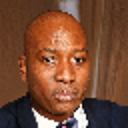

1

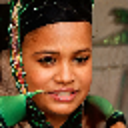

1

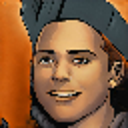

1

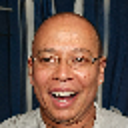

1

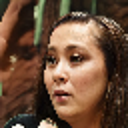

1

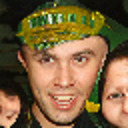

1

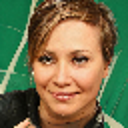

1

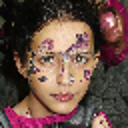

1

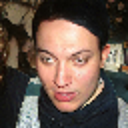

1

In [ ]:
for el in mistakes_optimal:
  img = tf.keras.preprocessing.image.array_to_img(images.numpy()[el])
  display(img.resize((128,128)),Image.LANCZOS)

# MULTILAYER-PERCEPTRON 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = optimal_batch_size

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
: Model Initialize
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
with strategy.scope():
  model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(64,64,3, )),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(200, activation='sigmoid'),
  tf.keras.layers.Dense(60, activation='sigmoid'),
  tf.keras.layers.Dense(1,activation = 'sigmoid')
  ])
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()
plot_training = PlotTraining(sample_rate=10, zoom=4)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 12288)             0         
                                                                 
 dense_6 (Dense)             (None, 200)               2457800   
                                                                 
 dense_7 (Dense)             (None, 60)                12060     
                                                                 
 dense_8 (Dense)             (None, 1)                 61        
                                                                 
Total params: 2,469,921
Trainable params: 2,469,921
Non-trainable params: 0
_________________________________________________________________


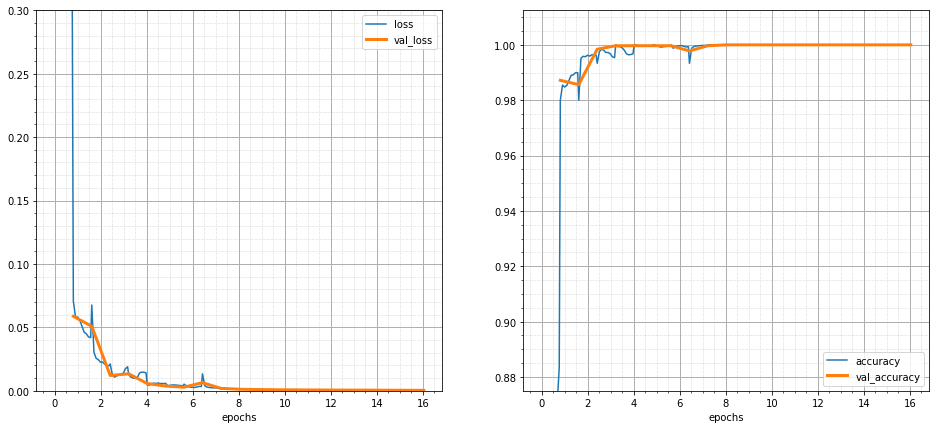

85/85 [==============================] - 3s 37ms/step - loss: 3.5777e-04 - accuracy: 1.0000 - val_loss: 3.6289e-04 - val_accuracy: 1.0000


In [ ]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets

import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from IPython.display import display, Javascript, clear_output, HTML
from google.colab import output
import io, base64


steps_per_epoch = 12800//optimal_batch_size

history = model.fit(training_data_opt,
                    epochs=20,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_data_opt,
                    validation_steps = 1,
                    initial_epoch = 0,
                    callbacks = [plot_training])

In [ ]:
histories.append(history)
result.append(model.evaluate(test_data_opt, steps = 1))

1/1 [==============================] - 1s 1s/step - loss: 0.0014 - accuracy: 0.9995


In [ ]:
images,true_labels = test_data_opt.take(1).get_single_element()
predictions = model.predict_on_batch(images)
metrics.accuracy_score(np.round(predictions),true_labels.numpy())

0.9995

In [ ]:
mistakes_perceptron = []
for index in range(len(predictions)):
  if np.round(predictions)[index] != true_labels[index]:
    mistakes_perceptron.append(index)
print(len(mistakes_perceptron))

2


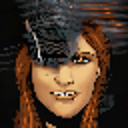

1

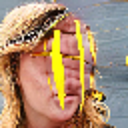

1

In [ ]:
for el in mistakes_perceptron:
  img = tf.keras.preprocessing.image.array_to_img(images.numpy()[el])
  display(img.resize((128,128)),Image.LANCZOS)

Training loss asymptotically decreases to 0 amd all the training images are correctly classified, validation accuracy decreases as well and the validation accuracy increases respect to the one layer model. The training set reaches the linear separability, while the validation set does not perform as good as the training one. The reason might be there are too many stacked layers or connections and a solutino might be to use regularization.

# REGULARIZATION

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = optimal_batch_size

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
: Model Initialize
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
with strategy.scope():
  model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(64,64,3, )),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(60, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1,activation = 'sigmoid')
  ])
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()
plot_training = PlotTraining(sample_rate=10, zoom=5)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 12288)             0         
                                                                 
 dense_9 (Dense)             (None, 200)               2457800   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 60)                12060     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 61        
                                                                 
Total params: 2,469,921
Trainable params: 2,469,921
No

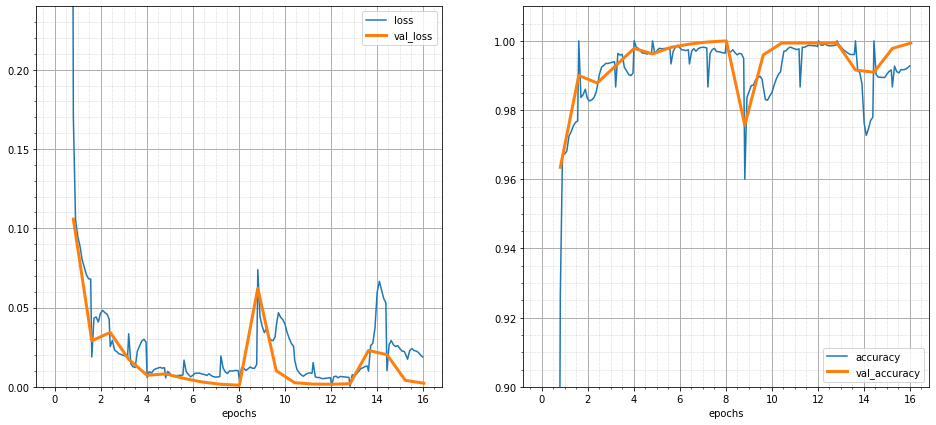

85/85 [==============================] - 3s 41ms/step - loss: 0.0184 - accuracy: 0.9929 - val_loss: 0.0022 - val_accuracy: 0.9994


In [ ]:
%matplotlib inline

steps_per_epoch = 12800//optimal_batch_size

history = model.fit(training_data_opt,
                    epochs=20,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_data_opt,
                    validation_steps = 1,
                    initial_epoch = 0,
                    callbacks = [plot_training])

In [ ]:
histories.append(history)
result.append(model.evaluate(test_data_opt, steps = 1))

1/1 [==============================] - 1s 1s/step - loss: 0.0036 - accuracy: 0.9988


In [ ]:
images,true_labels = test_data_opt.take(1).get_single_element()
predictions = model.predict_on_batch(images)
metrics.accuracy_score(np.round(predictions),true_labels.numpy())

0.99875

In [ ]:
mistakes_reg = []
for index in range(len(predictions)):
  if np.round(predictions)[index] != true_labels[index]:
    mistakes_reg.append(index)
print(len(mistakes_reg))

5


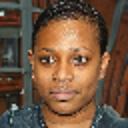

1

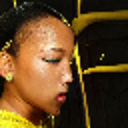

1

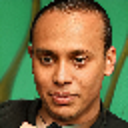

1

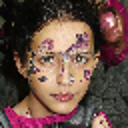

1

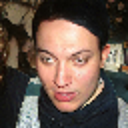

1

In [ ]:
for el in mistakes_reg:
  img = tf.keras.preprocessing.image.array_to_img(images.numpy()[el])
  display(img.resize((128,128)),Image.LANCZOS)

Performances get worse, validation accuracy still the same but the model is unstable given the difference training-validation curves. Furthermore, test accuracy decreases respect to the full model.

# CONVOLUTIONAL NETWORKS

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = optimal_batch_size

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
: Model Initialize
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
with strategy.scope():
  model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(64,64,3, )),
  tf.keras.layers.Conv2D(kernel_size=3, filters=12,
                            activation='relu', padding='same'),
  tf.keras.layers.Conv2D(kernel_size=6, filters=24,
                            activation='relu', padding='same', strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dense(1,activation = 'sigmoid')
  ])
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()
plot_training = PlotTraining(sample_rate=10, zoom=5)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 12)        336       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 24)        10392     
                                                                 
 flatten_8 (Flatten)         (None, 24576)             0         
                                                                 
 dense_12 (Dense)            (None, 200)               4915400   
                                                                 
 dense_13 (Dense)            (None, 1)                 201       
                                                                 
Total params: 4,926,329
Trainable params: 4,926,329
Non-trainable params: 0
_________________________________________________________________


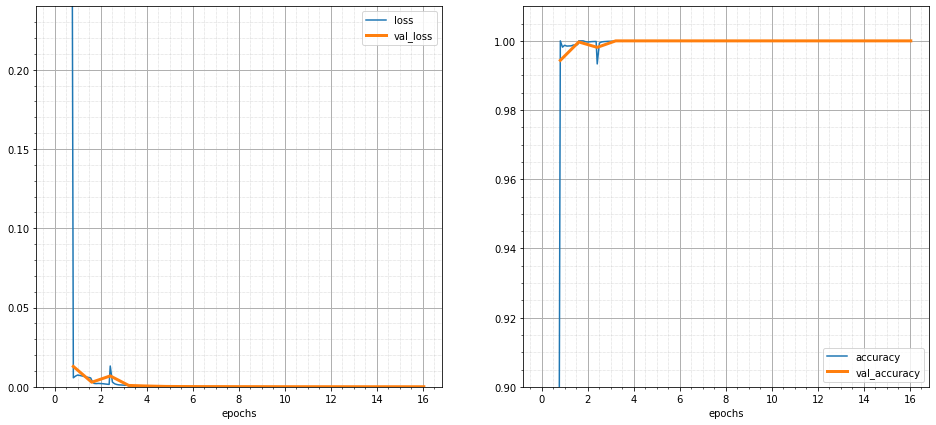

85/85 [==============================] - 3s 39ms/step - loss: 1.1819e-05 - accuracy: 1.0000 - val_loss: 3.1230e-05 - val_accuracy: 1.0000


In [ ]:
history = model.fit(training_data_opt,
                    epochs=20,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_data_opt,
                    validation_steps = 1,
                    initial_epoch = 0,
                    callbacks = [plot_training])

In [ ]:
histories.append(history)
result.append(model.evaluate(test_data_opt,steps=1))

1/1 [==============================] - 3s 3s/step - loss: 4.0563e-05 - accuracy: 1.0000


In [ ]:
images,true_labels = test_data_opt.take(1).get_single_element()
predictions = model.predict_on_batch(images)
metrics.accuracy_score(np.round(predictions),true_labels.numpy())

1.0

In [ ]:
mistakes_conv = []
for index in range(len(predictions)):
  if np.round(predictions)[index] != true_labels[index]:
    mistakes_conv.append(index)
print(len(mistakes_conv))

0


In [ ]:
for el in mistakes_conv:
  img = tf.keras.preprocessing.image.array_to_img(images.numpy()[el])
  display(img.resize((128,128)),Image.LANCZOS)

# RESULTS

In [ ]:
models = ['baseline','optimized_one_layer',' multi-layer Percepetron','regularized Perceptron', 'Convolutional network']
losses = []
accuracies = []
for loss,acc in result:
  losses.append(loss)
  accuracies.append(acc)

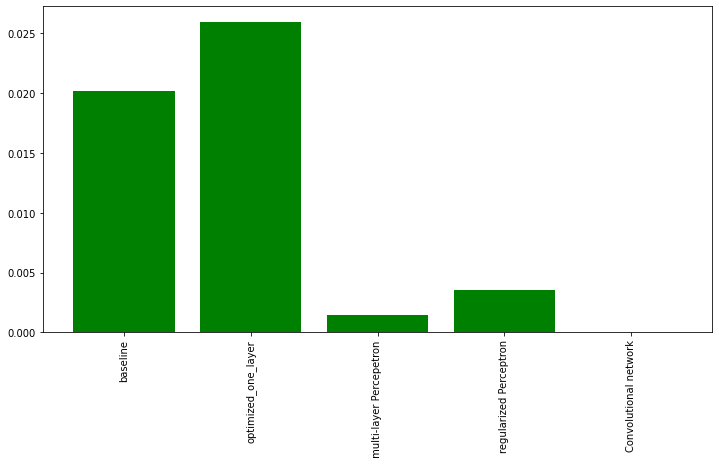

In [ ]:
fig, ax = plt.subplots(1,figsize=(12, 6))
ax.bar(models, losses, color='green', label='losses')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
import pandas as pd

loss_sum_up = pd.DataFrame()
for el in range(len(models)):
  model_sum_up = pd.DataFrame()
  model_sum_up['training_loss'] = histories[el].history["loss"]
  model_sum_up['validation_loss'] = histories[el].history["val_loss"]
  model_sum_up['models'] = models[el]
  model_sum_up['training_accuracy'] = histories[el].history["accuracy"]
  model_sum_up['validation_accuracy'] = histories[el].history["val_accuracy"]
  model_sum_up['epochs'] = list(range(1,21))
  loss_sum_up = loss_sum_up.append(model_sum_up)
loss_sum_up.reset_index(inplace=True)

[(-0.001, 0.1)]

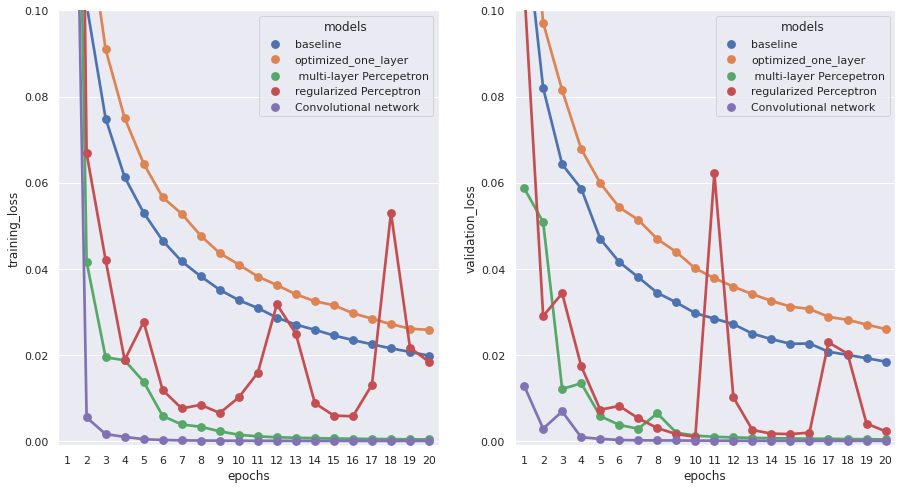

In [ ]:
import seaborn as sns 
sns.set_theme()
sns.set(rc={"figure.figsize":(15,8)}) 

fig, axes = plt.subplots(1,2)

tr = sns.pointplot(data=loss_sum_up, x = 'epochs', y='training_loss', hue='models',ax=axes[0])
tr.set(ylim=(-0.001,0.10))

val = sns.pointplot(data=loss_sum_up, x = 'epochs', y='validation_loss', hue='models', ax=axes[1])
val.set(ylim=(-0.001,0.10))



[(0.985, 1.001)]

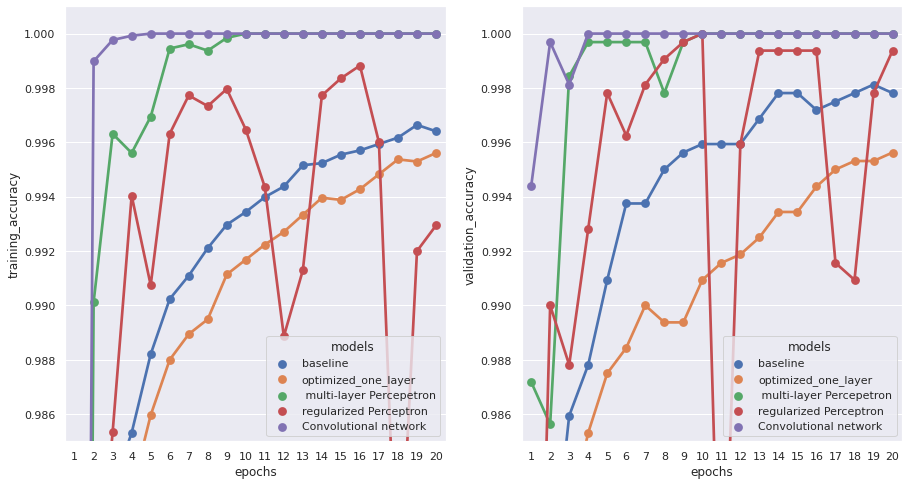

In [ ]:
fig, axes = plt.subplots(1,2)

tr_acc = sns.pointplot(data=loss_sum_up, x = 'epochs', y='training_accuracy', hue='models',ax=axes[0])
tr_acc.set(ylim=(0.985,1.001))

val_acc = sns.pointplot(data=loss_sum_up, x = 'epochs', y='validation_accuracy', hue='models', ax=axes[1])
val_acc.set(ylim=(0.985,1.001))

In [ ]:
mistakes_list = [mistakes_baseline,mistakes_optimal,mistakes_perceptron,mistakes_reg,mistakes_conv]
numb_mistakes = []
for el in mistakes_list:
  numb_mistakes.append(len(el))

Text(0, 0.5, 'number of mistakes')

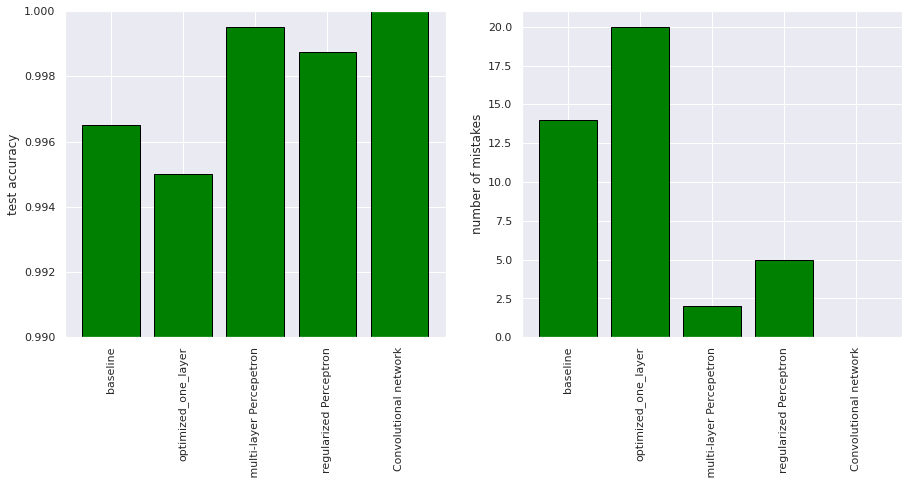

In [ ]:
fig = plt.figure(figsize=(15,6))
sns.set_theme()

ax = fig.add_subplot(1,2,1)

ax.bar(models, accuracies, color='green', label='test_losses',edgecolor = 'black')
plt.xticks(rotation = 90)
plt.ylim(0.99,1.0)
plt.ylabel('test accuracy')

ax1 = fig.add_subplot(1,2,2)

ax1.bar(models, numb_mistakes, color='green', label='number of mistakes',edgecolor = 'black')
plt.xticks(rotation = 90)
plt.ylabel('number of mistakes')

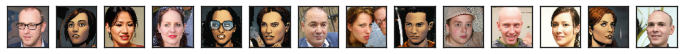

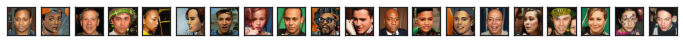

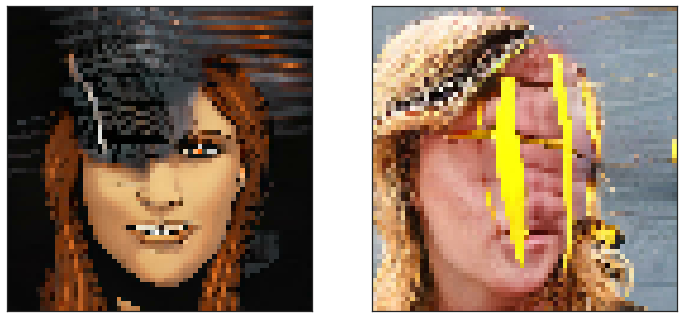

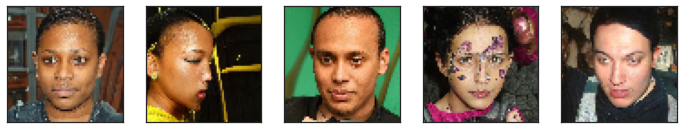

<Figure size 864x432 with 0 Axes>

In [ ]:
sns.set_theme(style='white')

for model in mistakes_list:
  fig = plt.figure(figsize = (12,6))
  counter = 1
  for el in model:
    ax = fig.add_subplot(1,len(model), counter)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    counter += 1
    img = images.numpy()[el]
    plt.imshow(img)

In conclusion, convolutional model outperforms the others in terms of loss and accuracy with a misclassification rate equal to 0 over an image test dataset composed by 4000 instances. 